# Setup

Importar librerías

In [19]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
from datetime import datetime
from time import sleep

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [20]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

1 Physical GPUs, 1 Logical GPUs


# Carga del dataset

In [21]:
total_ds, info  = tfds.load('spoken_digit', with_info=True, as_supervised=False,shuffle_files=True)
info

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/spoken_digit/incomplete.KBFMD7_1.0.9/spoken_digit-train.tfrecord*...:   0%…

Dataset spoken_digit downloaded and prepared to /root/tensorflow_datasets/spoken_digit/1.0.9. Subsequent calls will reuse this data.


tfds.core.DatasetInfo(
    name='spoken_digit',
    full_name='spoken_digit/1.0.9',
    description="""
    A free audio dataset of spoken digits. Think MNIST for audio.
    
    A simple audio/speech dataset consisting of recordings of spoken digits in wav
    files at 8kHz.
    The recordings are trimmed so that they have near minimal silence at the
    beginnings and ends.
    
    5 speakers\
    2,500 recordings (50 of each digit per speaker)\
    English pronunciations
    
    Files are named in the following format: {digitLabel}_{speakerName}_{index}.wav
    """,
    homepage='https://github.com/Jakobovski/free-spoken-digit-dataset',
    data_dir='/root/tensorflow_datasets/spoken_digit/1.0.9',
    file_format=tfrecord,
    download_size=11.42 MiB,
    dataset_size=45.68 MiB,
    features=FeaturesDict({
        'audio': Audio(shape=(None,), dtype=int64),
        'audio/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
  

In [22]:
num_clases = info.features['label'].num_classes

In [23]:
total_ds = total_ds['train']
total_ds.element_spec

{'audio': TensorSpec(shape=(None,), dtype=tf.int64, name=None),
 'audio/filename': TensorSpec(shape=(), dtype=tf.string, name=None),
 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}

# División del dataset

In [24]:
size_train_ds = int(0.8*len(total_ds))
size_val_ds = int(0.2*len(total_ds))
train_ds = total_ds.take(size_train_ds)
val_ds = total_ds.take(size_val_ds)
print(len(train_ds))
print(len(val_ds))

2000
500


# Análisis balanceo y extensión del audio

In [25]:
train_etiquetas = np.array([])
train_largo_señal = np.array([])
for muestra in train_ds:
  etiqueta = muestra['label']
  audio = muestra['audio']
  train_etiquetas = np.append(train_etiquetas,etiqueta)
  train_largo_señal = np.append(train_largo_señal,len(audio))

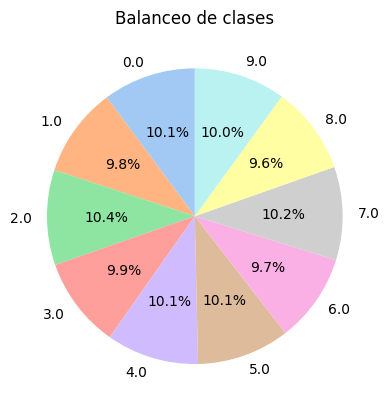

In [26]:
def val_abs(val):
    return f"{val:.1f}%"
etiquetas,porciones = np.unique(train_etiquetas,return_counts=True)
colores = sns.color_palette('pastel')
plt.pie(x=porciones,autopct=val_abs,labels=etiquetas,colors=colores,startangle=90)
plt.title('Balanceo de clases')
plt.show()

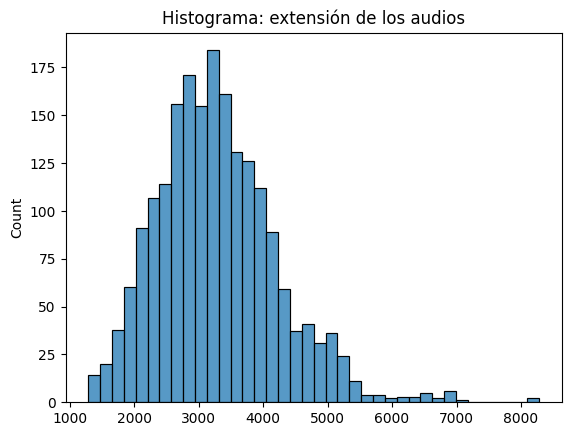

In [27]:
sns.histplot(train_largo_señal)
plt.title('Histograma: extensión de los audios')
plt.show()

# Forma de las ondas según ejemplos

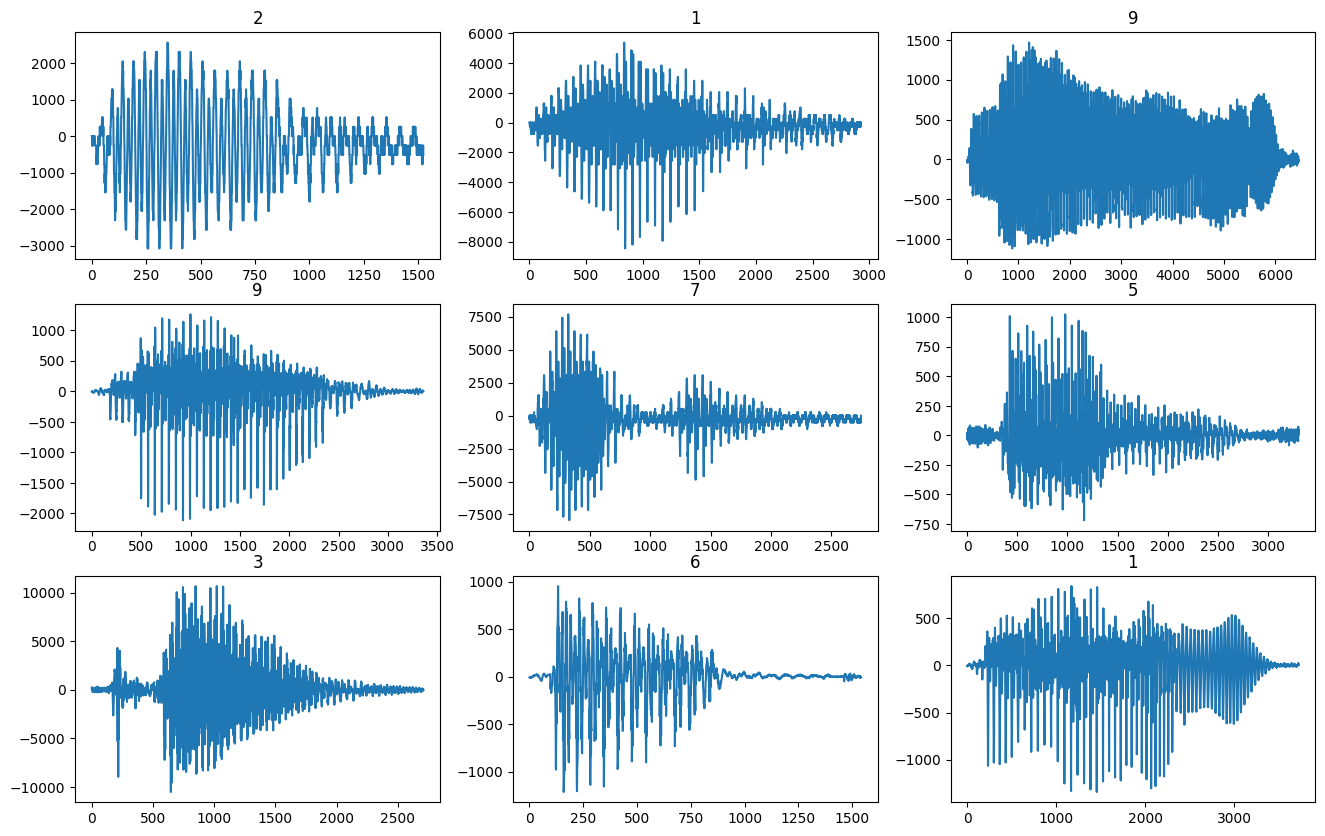

In [28]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i,muestra in enumerate(train_ds.take(n)):
  plt.subplot(rows, cols, i+1)
  audio_signal = muestra['audio']
  plt.plot(audio_signal)
  plt.title(muestra['label'].numpy())
  # plt.yticks(np.arange(-1.2, 1.2, 0.2))
  # plt.ylim([-1.1, 1.1])

# Convertir formas de onda a espectrogramas

Las formas de onda en el conjunto de datos están representadas en el dominio del tiempo. A continuación, se transforman las formas de onda de señales del dominio del tiempo a señales del dominio tiempo-frecuencia al calcular la [transformada de Fourier de corto tiempo (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) para convertir las formas de onda en [espectrogramas](https://en.wikipedia.org/wiki/Spectrogram), que muestran cambios de frecuencia a lo largo del tiempo y pueden ser representados como imágenes 2D.

La STFT (`tf.signal.stft`) divide la señal en ventanas de tiempo y ejecuta una transformada de Fourier en cada ventana, preservando parte de la información temporal, y devolviendo un tensor 2D.

Se define una función de utilidad para convertir formas de onda a espectrogramas:

- Las formas de onda deben tener la misma longitud, de modo que cuando se conviertan en espectrogramas, los resultados tengan dimensiones similares.
- Al llamar a `tf.signal.stft`, elegir los parámetros `frame_length` y `frame_step` de tal manera que la "imagen" de espectrograma generada sea casi cuadrada. Para obtener más información sobre la elección de los parámetros de la STFT, consultar este [video de Coursera](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) sobre procesamiento de señales de audio y STFT.
- La STFT produce una matriz de números complejos que representan magnitud y fase. Sin embargo, en este tutorial solo utilizaremos la magnitud, que podemos derivar aplicando `tf.abs` en la salida de `tf.signal.stft`.

In [29]:
def get_spectrogram(waveform):
  waveform = tf.cast(waveform, tf.float32)
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

Imprimir las formas de uno de los ejemplos de la forma de onda tensorizada y el espectrograma correspondiente, y reproducir el audio original:

In [30]:
for muestra in train_ds.take(5):
  label = muestra['label'].numpy()
  waveform = muestra['audio']
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=8000))

Label: 2
Waveform shape: (1525,)
Spectrogram shape: (10, 129, 1)
Audio playback


Label: 1
Waveform shape: (2929,)
Spectrogram shape: (21, 129, 1)
Audio playback


Label: 9
Waveform shape: (6457,)
Spectrogram shape: (49, 129, 1)
Audio playback


Label: 9
Waveform shape: (3360,)
Spectrogram shape: (25, 129, 1)
Audio playback


Label: 7
Waveform shape: (2746,)
Spectrogram shape: (20, 129, 1)
Audio playback


Definimos una función para mostrar el espectrograma:

In [31]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Ploteamos formas de onda y sus respectivos espectrogramas.

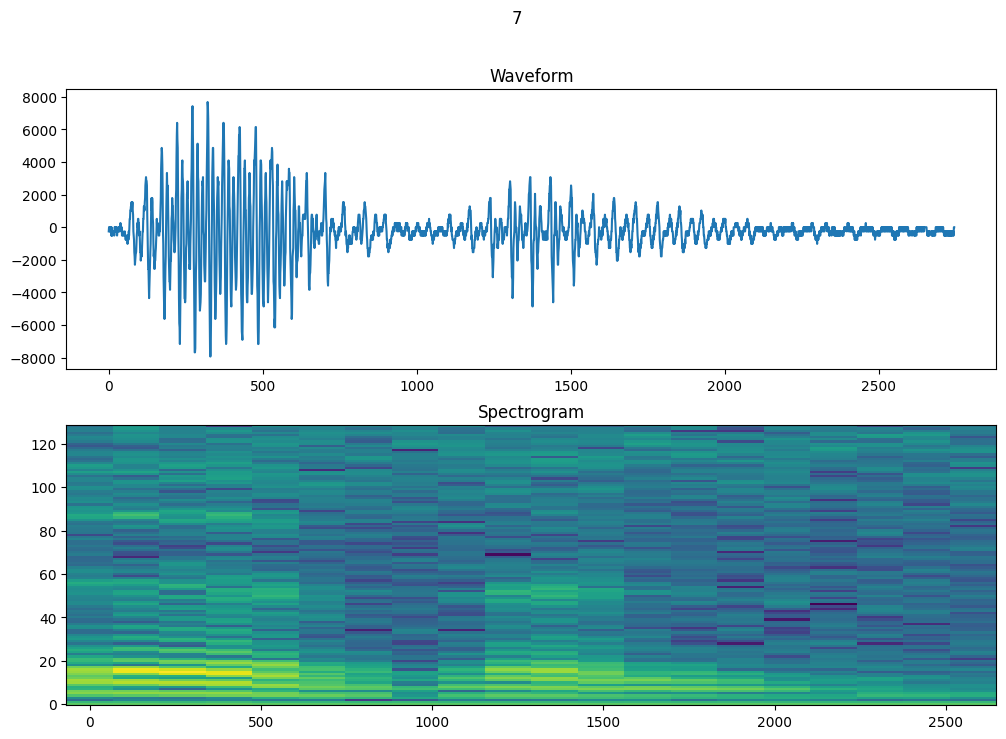

In [32]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label)
plt.show()

Examinar el espectrograma para distintos ejemplos del dataset.

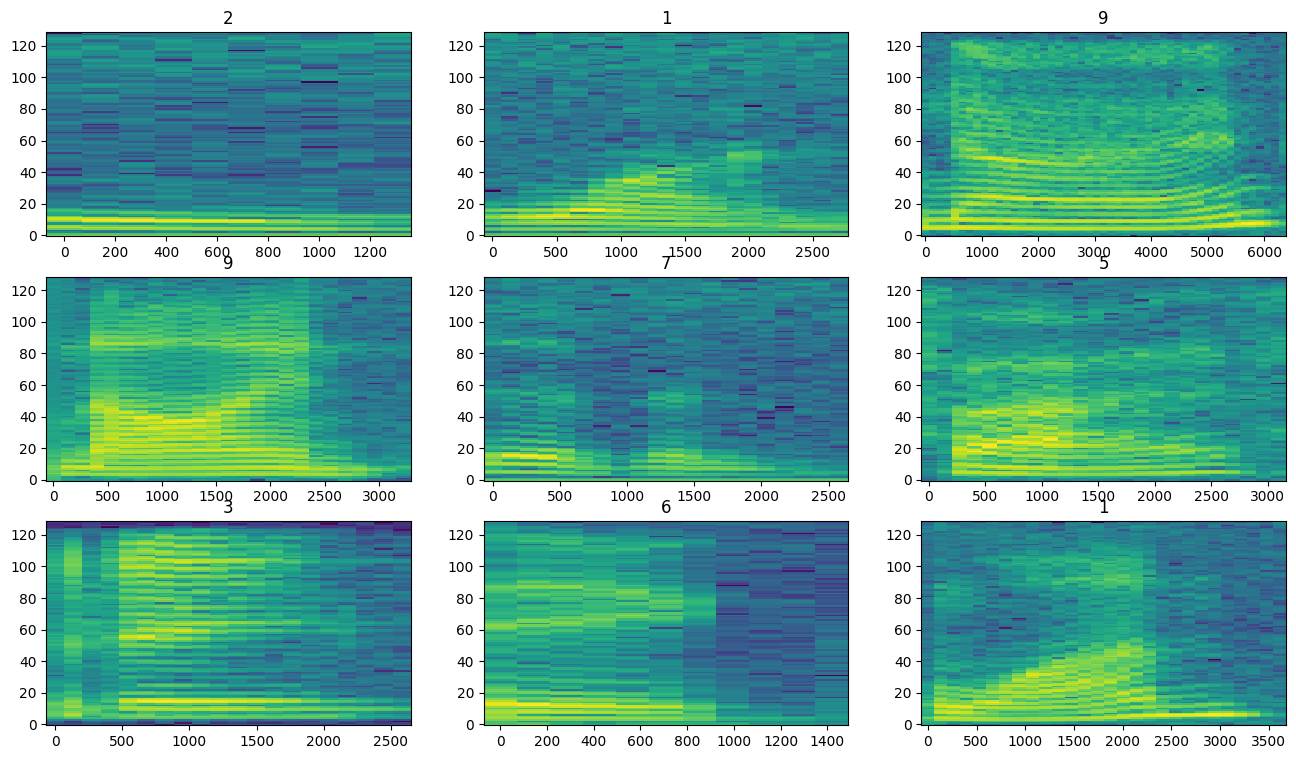

In [33]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i,muestra in enumerate(train_ds.take(n)):
    waveform = muestra['audio']
    spectrogram = get_spectrogram(waveform)
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(spectrogram.numpy(), ax)
    ax.set_title(muestra['label'].numpy())

plt.show()

Normalización

In [34]:
def normalize_audio_length(example, target_length=8000):
    audio = example['audio']
    current_length = tf.shape(audio)[0]

    # Padding si es más corto
    padding_needed = tf.maximum(target_length - current_length, 0)
    audio = tf.pad(audio, [[0, padding_needed]])

    # Truncar si es más largo
    audio = audio[:target_length]

    # Mantener todas las claves originales (label, filename, etc.)
    return {
        'audio': audio,
        'label': example['label'],
        'audio/filename': example['audio/filename'],
    }

# Aplicar la normalización
train_ds = train_ds.map(normalize_audio_length, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.map(normalize_audio_length, num_parallel_calls=tf.data.AUTOTUNE)

Ahora creamos un dataset de espectrogramas utilizando la función definida.

In [35]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda muestra: (get_spectrogram(muestra['audio']), muestra['label']),
      num_parallel_calls=tf.data.AUTOTUNE)

In [36]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)

Batch



In [37]:
train_spectrogram_ds = train_spectrogram_ds.batch(64)
val_spectrogram_ds = val_spectrogram_ds.batch(64)

In [38]:
train_spectrogram_ds.element_spec

(TensorSpec(shape=(None, None, 129, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int64, name=None))

Optimizamos la carga del dataset

In [39]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

In [40]:
for examples_spectrograms, labels in train_spectrogram_ds.take(1):
  break

In [41]:
examples_spectrograms.shape

TensorShape([64, 61, 129, 1])

In [42]:
for espectrogramas,etiquetas in train_spectrogram_ds.take(1):
  espectrograma = espectrogramas[0]
  print(espectrograma.shape)
  for i in range(129):
    vector = espectrograma[:,i,:].numpy().reshape(-1)
    print('-------------------Vector número ',i,'-----------------')
    print(vector)
    print('\n\n')

  #print(audio[:,0])

(61, 129, 1)
-------------------Vector número  0 -----------------
[255.59628   74.72263  412.36258   67.53171   32.24077   41.864105
 558.63367   95.755936 237.44507  190.26521  119.50282  317.39557
 224.99388   17.0279    15.259735 170.50807  157.12732   89.44281
 115.121475 236.64789  106.77766  304.49753  122.00049  103.952095
 220.79413  421.71216    0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.         0.         0.         0.         0.         0.
   0.      ]



-------------------Vector número  1 -----------------
[194.8664   103.27742  384.41254  124.13844  122.2321   208.82658
 468.58228  333.3767   111.40313  120.811516 198.39323  174.59831
 297.4409   260.16968  180.44424   48.053955 182.18654  101.71375
 222.11922  246.9455   278.89737 

# Modelo convolucional

Para el modelo, se utilizará una red neuronal convolucional simple (CNN), ya que se han transformado los archivos de audio en imágenes de espectrograma.

El modelo `tf.keras.Sequential` utilizará las siguientes capas de preprocesamiento de Keras:

- `tf.keras.layers.Resizing`: para reducir la resolución de la entrada y permitir que el modelo entrene más rápido.
- `tf.keras.layers.Normalization`: para normalizar cada píxel en la imagen basándose en su media y desviación estándar.

Para la capa de Normalización, primero se debe llamar a su método `adapt` en los datos de entrenamiento para calcular las estadísticas agregadas (es decir, la media y la desviación estándar).

In [43]:
input_shape_conv = examples_spectrograms.shape[1:]
print('Input shape:', input_shape_conv)
num_labels = num_clases

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

model_conv = models.Sequential([
    layers.Input(shape=input_shape_conv),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model_conv.summary()

Input shape: (61, 129, 1)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resizing (Resizing)             │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ normalization (Normalization)   │ (None, 32, 32, 1)      │             3 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 28, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,605,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         1,290 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,625,869 (6.20 MB)

 Trainable params: 1,625,866 (6.20 MB)

 Non-trainable params: 3 (16.00 B)

Compilamos el modelo:

In [44]:
model_conv.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Entrenamos durante 50 epochs con early stopping:

In [65]:
EPOCHS = 50
history_conv = model_conv.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9971 - loss: 0.0165 - val_accuracy: 1.0000 - val_loss: 7.2672e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9865 - loss: 0.0377 - val_accuracy: 1.0000 - val_loss: 9.6857e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9926 - loss: 0.0265 - val_accuracy: 1.0000 - val_loss: 6.4964e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9910 - loss: 0.0288 - val_accuracy: 1.0000 - val_loss: 8.6991e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9947 - loss: 0.0178 - val_accuracy: 1.0000 - val_loss: 6.9467e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9860 - loss: 0.0385 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9947 - loss: 0.0212 - val_accuracy: 1.0000 - val_loss: 4.9902e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9945 - loss: 0.0145 - val_accu

Ploteamos resultados:

Text(0, 0.5, 'Accuracy [%]')

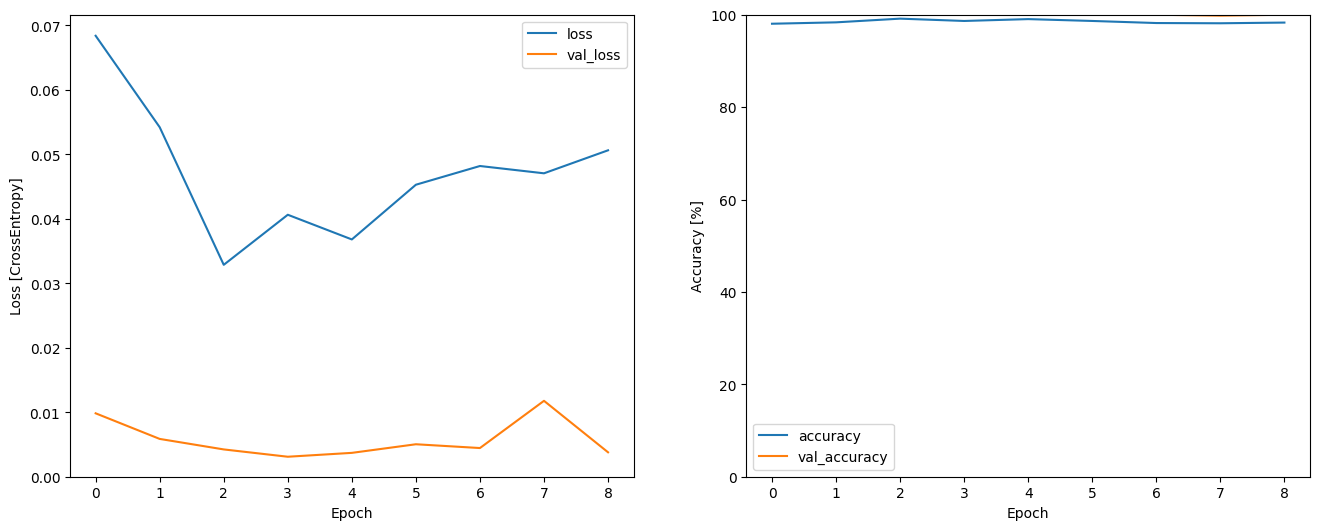

In [47]:
metrics = history_conv.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_conv.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_conv.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Mostrar una matriz de confusión

Utilizar una [matriz de confusión](https://developers.google.com/machine-learning/glossary#confusion-matrix) para verificar qué tan bien clasificó el modelo cada uno de los comandos en el conjunto de prueba:

In [48]:
y_pred_conv = model_conv.predict(val_spectrogram_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step


In [49]:
y_pred_conv = tf.argmax(y_pred_conv, axis=1)

In [50]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

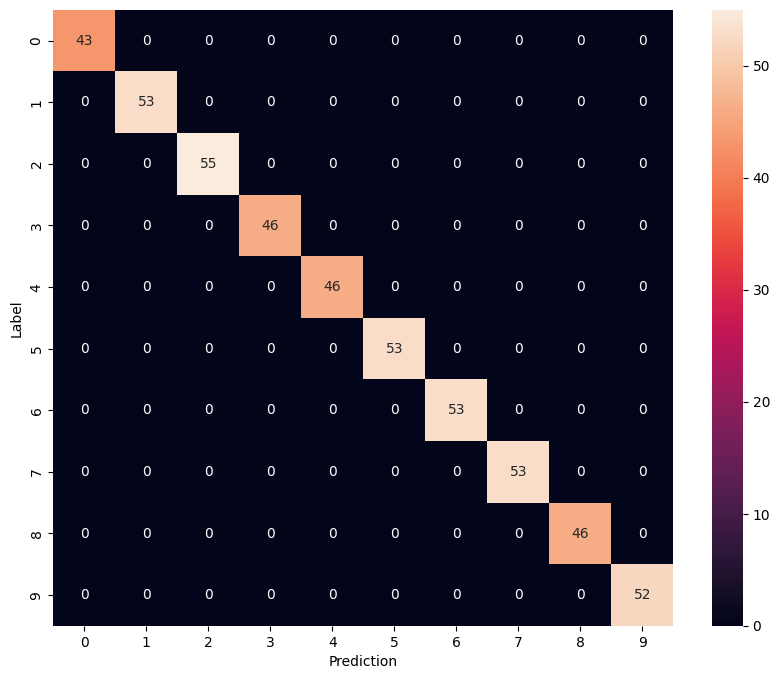

In [51]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_conv)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=range(num_clases),
            yticklabels=range(num_clases),
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferir sobre un archivo de audio

Finalmente, inferimos sobre un archivo de audio (en este caso tomamos un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

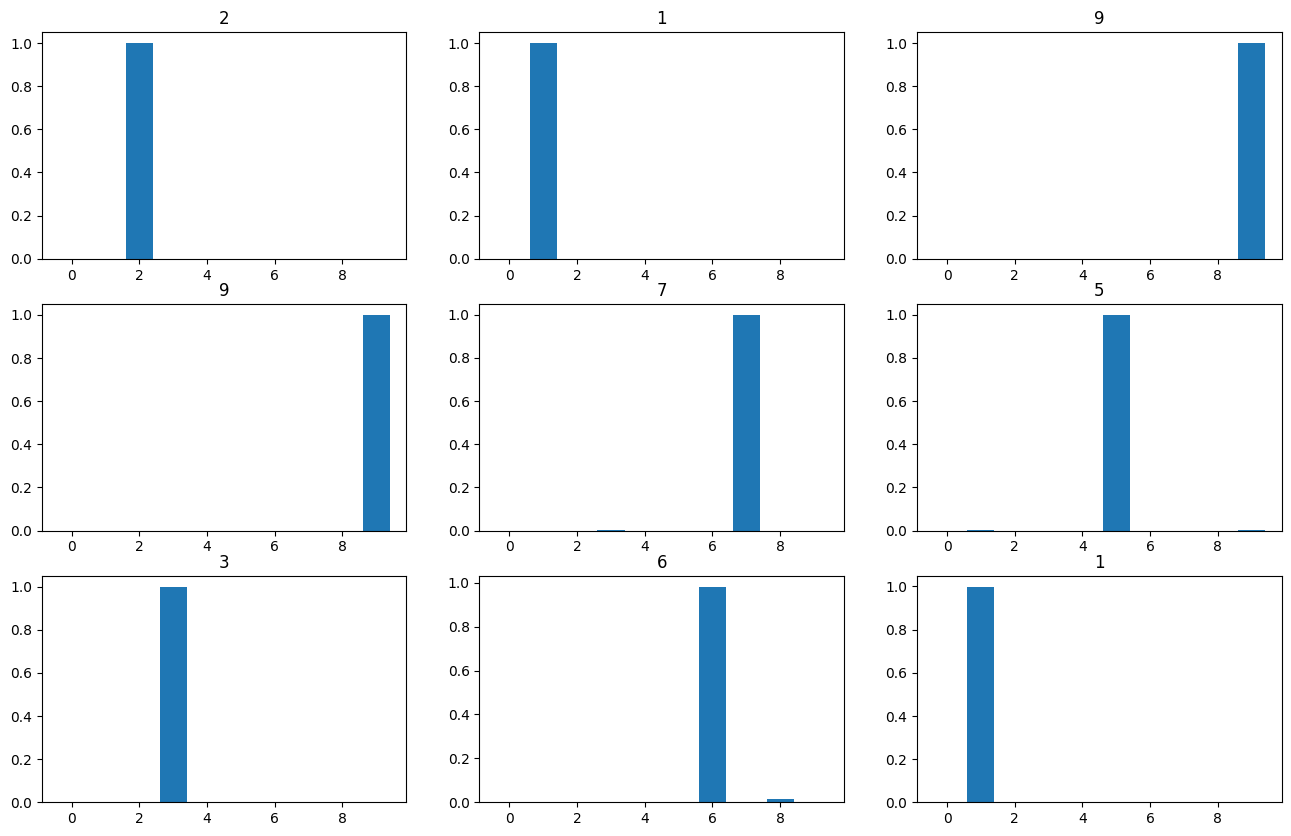

In [52]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i,muestra in enumerate(train_ds.take(n)):
  waveform = muestra['audio']
  x = get_spectrogram(waveform)
  x = x[tf.newaxis,...]
  prediction = model_conv(x)
  x_labels = range(num_clases)
  plt.subplot(rows,cols,i+1)
  plt.bar(x_labels, tf.nn.softmax(prediction[0]))
  plt.title(muestra['label'].numpy())
  display.display(display.Audio(waveform, rate=8000))
plt.show()

# Modelo Recurrente

Adaptar el preprocesamiento y modelo utilizando redes recurrentes. Interpretar al espectrograma como una secuencia de vectores de amplitud frecuencial.

In [53]:
input_shape_rec = examples_spectrograms.shape[1:-1]
print('Input shape:', input_shape_rec)
num_labels = num_clases

# # Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# # Fit the state of the layer to the spectrograms
# # with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label:tf.reshape(spec, (-1, input_shape_rec[-1]))    ))

model_rec = models.Sequential([
    layers.Input(shape=input_shape_rec),
    # Downsample the input.
    #layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(num_labels)
])
model_rec.summary()

Input shape: (61, 129)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization_1 (Normalization) │ (None, 61, 129)        │           259 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 128)            │        99,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 108,493 (423.80 KB)

 Trainable params: 108,234 (422.79 KB)

 Non-trainable params: 259 (1.02 KB)

Compilamos el modelo:

In [54]:
model_rec.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

Entrenamos durante 50 epochs con early stopping:

In [64]:
EPOCHS = 50
history_rec = model_rec.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),
)


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 1.6156e-04 - val_accuracy: 1.0000 - val_loss: 1.8331e-04
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.6334e-04 - val_accuracy: 1.0000 - val_loss: 1.7120e-04
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.3727e-04 - val_accuracy: 1.0000 - val_loss: 1.6825e-04
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 1.2738e-04 - val_accuracy: 1.0000 - val_loss: 1.6274e-04
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.2774e-04 - val_accuracy: 1.0000 - val_loss: 1.5795e-04
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 1.0000 - loss: 1.1941e-04 - val_accuracy: 1.0000 - val_loss: 1.5448e-04
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 1.4365e-04 - val_accuracy: 1.0000 - val_loss: 1.4880e-04
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accu

Ploteamos resultados:

In [ ]:
metrics = history_rec.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history_rec.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history_rec.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Mostrar una matriz de confusión

Utilizar una [matriz de confusión](https://developers.google.com/machine-learning/glossary#confusion-matrix) para verificar qué tan bien clasificó el modelo cada uno de los comandos en el conjunto de prueba:

In [ ]:
y_pred_rec = model_rec.predict(val_spectrogram_ds)

In [ ]:
y_pred_rec = tf.argmax(y_pred_rec, axis=1)

In [ ]:
y_true = tf.concat(list(val_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred_rec)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=range(num_clases),
            yticklabels=range(num_clases),
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Inferir sobre un archivo de audio

Finalmente, inferimos sobre un archivo de audio (en este caso tomamos un archivo del dataset arbitrario, podría ser un archivo .wav completamente nuevo).

In [ ]:
plt.figure(figsize=(16, 10))
rows = 3
cols = 3
n = rows * cols
for i,muestra in enumerate(train_ds.take(n)):
  waveform = muestra['audio']
  x = get_spectrogram(waveform)
  x = x[tf.newaxis,...]
  prediction = model_rec(x)
  x_labels = range(num_clases)
  plt.subplot(rows,cols,i+1)
  plt.bar(x_labels, tf.nn.softmax(prediction[0]))
  plt.title(muestra['label'].numpy())
  display.display(display.Audio(waveform, rate=8000))
plt.show()